In [ ]:
import math
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
from scipy import fftpack
import pandas as pd
from matplotlib.colors import LogNorm
from scipy.fftpack import fft2
from scipy.fftpack import ifft2

1\. **Hurricanes per Year**

The number of hurricanes in 2005 was 15. The historic average is 6.3. Is this number signficantly different?
- Assume the number of hurricanes is random, i.e. follows the Poisson distribution.
- Assume as statistically significant a probability that has a Z score of 3 or larger with respect a normal distribution.

**Hint**: compute the probability that in a single year are observed 15 or more hurricances.

In [49]:
x = 15

avg = 6.3

sigma= math.sqrt(avg)

Z = (x-avg)/sigma   

pvalue = stats.norm.cdf(-Z) + (1. - stats.norm.cdf(Z))


print("The Z is:")
print(Z)

print("The pvalue is:")
print(pvalue)

The Z is:
3.4661629670697414
The pvalue is:
0.0005279431738299246


2\. **Pairwise t-test**

In an experiment, a group of 10 individuals agreed to participate in a study of blood pressure changes following exposure to halogen lighting. Resting systolic blood pressure was recorded for each individual. The participants were then exposed to 20 minutes in a room lit only by halogen lamps. A post-exposure systolic blood pressure reading was recorded for each individual. The results are presented in the following data set:

```python
pre = np.array([120, 132, 120, 110, 115, 128, 120, 112, 110, 100])
post = np.array([140, 156, 145, 130, 117, 148, 137, 119, 127, 135])
```

Determine whether the change in blood pressures within our sample was statistically significant.

**Hint:**
in this case, the Student's $t$-test should be performed to compare the two datasets.
Use the following test statistics:

$$T = \frac{\bar{x}_1 - \bar{x}_2}{\sigma \sqrt{\frac{2}{n}}}$$

and 

$$\sigma = \sqrt{\frac{\sigma_1^2 + \sigma_2^2}{2}}$$

In [54]:
pre = np.array([120, 132, 120, 110, 115, 128, 120, 112, 110, 100])

post = np.array([140, 156, 145, 130, 117, 148, 137, 119, 127, 135])


T= (np.mean(pre) - np.mean(post))/ (sigma* np.sqrt(2/pre.size))

sigma = np.sqrt((np.std(pre)**2 + np.mean(post)**2)/2)

p_value = stats.t.cdf(T, pre.size - 1) + (1. - stats.t.cdf(-T, pre.size - 1))

print("The sigma is:")
print(sigma)

print("The T is:")
print("T is", T)

print("The p_value is")
print(p_value)

The sigma is:
95.94782436303598
The T is:
T is -0.43580426608771705
The p_value is
0.6732444649028103


3\. **FFT of a simple dataset**

Perform a periodicity analysis on the lynxs-hares population, i.e. determine what is the period of the population of these animals.

The period of hare population is:
(1.397233477714126e-06+0j)
(423500-0j)
The period of lynx population is:
(2.361275088547816e-06+0j)


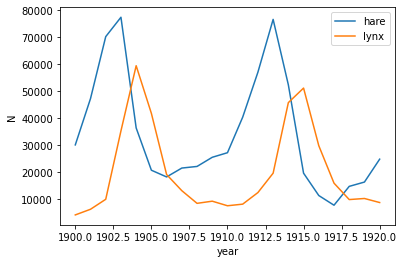

In [87]:
data = np.loadtxt("populations.txt")

year= []
hare= []
lynx= []

for i in range(data[:,0].size):
    
    year.append((data[:,0][i]))

for i in range(data[:,1].size):
    
    hare.append(data[:,1][i])

for i in range(data[:,2].size):
    
    lynx.append(data[:,2][i])


#Plotting the data
plt.plot(year, hare, label='hare') 

plt.plot(year, lynx, label='lynx')

plt.legend()

plt.xlabel('year')

plt.ylabel('N')


#Hare analysis

fft = fftpack.fft(hare)

power = np.abs(fft)

freq = fftpack.fftfreq(len(hare), year[1] - year[0])

pos_mask = np.where(fft  > 0)

freqs = fft [pos_mask]

powes = power[pos_mask]

peak_freq = freqs[powes.argmax()]

Period= 1/peak_freq

print("The period of hare population is:")
print(Period)


#Lynx analysis

fft = fftpack.fft(lynx)

power = np.abs(fft)

freq = fftpack.fftfreq(len(lynx), year[1] - year[0])

pos_mask = np.where(lynx_fft  > 0)

freqs = fft [pos_mask]

powes = power[pos_mask]

peak_freq = freqs[powes.argmax()]

print(peak_freq)

Period= 1/peak_freq

print("The period of lynx population is:")
print(Period)

4\. **FFT of an image**

Write a filter that removes the periodic noise from the `moonlanding.png` image by using a 2-dimensional FFT.

* Import the image as a 2D numpy array using `plt.imread("moonlanding.png")`. Examine the image with `plt.imshow()`, which is heavily contaminated with periodic noise.
* Check the documentation of the `scipy.fftpack` package, and find the method that performs a 2D FFT. Plot the spectrum (Fourier transform of) the image. **Hint**: use `LogNorm` to plot the colors in log scale:
```Python
from matplotlib.colors import LogNorm
plt.imshow(image, norm=LogNorm(vmin=5))
```
* Inspect the spectrum, and try to locate the regions of the power spectrum that contain the signal and those which contain the periodic noise. Use array slicing to set the noise regions to zero.
* Apply the inverse Fourier transform to plot the resulting image.

Text(0.5, 1.0, 'Noiseless Image')

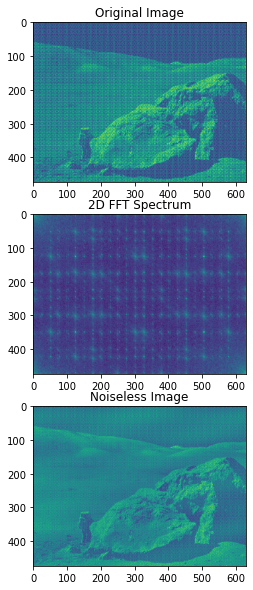

In [89]:
fig , (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(15,10))

Img = plt.imread("moonlanding.png")

ax1.imshow(Img)

ax1.set_title('Original Image')

Img_FFT= fft2(Img)

power = np.abs(Img_FFT)

ax2.imshow(power, norm=LogNorm(vmin=5))

ax2.set_title('2D FFT Spectrum')

threshold_freq = 2700

Img_FFT[np.abs(Img_FFT) > threshold_freq] = 0

Inverse_FFT= ifft2(Img_FFT)

Real_IFFT = Inverse_FFT.real

ax3.imshow(Real_IFFT)

ax3.set_title('Noiseless Image')